In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression


def ope(a_num=500, x_dim=5, n_iter_big=15, n_iter=15, train_rounds=1000, test_rounds=100000, noise_std=0.1):
    df_all = pd.DataFrame()
    for _ in range(n_iter_big):
        a = np.arange(a_num)
        e_a = np.random.randn(a_num, x_dim + 1) # Initialize the model parameters

        model_a = [LogisticRegression() for _ in a]
        for i in a:
            model_a[i].classes_ = np.array([0, 1])
            model_a[i].intercept_ = e_a[i, -1:]
            model_a[i].coef_ = e_a[i, :-1][:, np.newaxis].T

        # On-policy evaluation
        pi_e = np.ones(a_num) / a_num
        x_test = np.random.randn(test_rounds, x_dim)
        a_test = np.random.choice(a, test_rounds, p=pi_e)
        r_test = np.array([model_a[a_test[i]].predict_proba([x_test[i]])[0] for i in range(test_rounds)])[:, 1]
        value_test = r_test.mean() # ground truth policy value 
        # print(f"Test value: {value_test}")

        pi_0 = (pi_0 := np.abs(np.random.exponential(size=a_num))) / pi_0.sum()
        df = pd.DataFrame()

        for _ in range(n_iter):
            # Sample the logged dataset
            x_train = np.random.randn(train_rounds, x_dim)
            a_train = np.random.choice(a, train_rounds, p=pi_0)
            r_train = np.array([model_a[a_train[i]].predict_proba([x_train[i]])[0] for i in range(train_rounds)])[:, 1] + (np.random.randn(train_rounds) * noise_std)

            # IPS
            acc_value = 0
            for x_t, a_t, r_t in zip(x_train, a_train, r_train):
                acc_value += pi_e[a_t] / pi_0[a_t] * r_t

            result_ips = acc_value / len(x_train)
            # print(f"IPS: {result_ips}")

            # DM
            a_u = np.unique(a_train)
            dm_a = [LinearRegression() for _ in a]
            for i in a_u:
                mask = a_train == i
                dm_a[i].fit(x_train[mask], r_train[mask])

            acc_value = 0
            for x_t, a_t, r_t in zip(x_train, a_train, r_train):
                acc_value += sum([dm_a[i].predict([x_t]).sum() * pi_e[i] for i in a_u])

            result_dm = acc_value / len(x_train)
            # print(f"DM: {result_dm}")

            # DR
            acc_value = 0
            for x_t, a_t, r_t in zip(x_train, a_train, r_train):
                acc_value += sum([dm_a[i].predict([x_t]).sum() * pi_e[i] for i in a_u])
                acc_value += pi_e[a_t] / pi_0[a_t] * (r_t - dm_a[a_t].predict([x_t]).sum())

            result_dr = acc_value / len(x_train)
            # print(f"DR: {result_dr}")

            # Learned MIPS
            w_x_a = pi_e / pi_0
            pi_a_e = np.zeros((train_rounds, len(a)))
            e_hat = np.zeros((a_num, x_dim + 1))
            for i in a_u:
                e_hat[i, :-1] = dm_a[i].coef_
                e_hat[i, -1] = dm_a[i].intercept_
            pi_a_e_estimator = LogisticRegression(max_iter=100000).fit(e_hat[a_train], a_train)
            pi_a_e[:, np.unique(a_train)] = pi_a_e_estimator.predict_proba(e_hat[a_train])
            w_x_e = (w_x_a * pi_a_e).sum(1)
            result_learned_mips = w_x_e @ r_train / len(x_train)
            # print(f"Learned MIPS: {result_learned_mips}")

            # MIPS using true embeddings
            w_x_a = pi_e / pi_0
            pi_a_e = np.zeros((train_rounds, len(a)))
            pi_a_e_estimator = LogisticRegression(max_iter=100000).fit(e_a[a_train], a_train)
            pi_a_e[:, np.unique(a_train)] = pi_a_e_estimator.predict_proba(e_a[a_train])
            w_x_e = (w_x_a * pi_a_e).sum(1)
            result_mips = w_x_e @ r_train / len(x_train)
            # print(f"MIPS: {result_mips}")

            df = df.append({
                'IPS': (result_ips - value_test) ** 2, 'DM': (result_dm - value_test) ** 2, 'DR': (result_dr - value_test) ** 2, 'Learned MIPS': (result_learned_mips - value_test) ** 2, 'MIPS': (result_mips - value_test) ** 2,
                'n_actions': a_num, 'x_dim': x_dim, 'sample_size': train_rounds
            }, ignore_index=True)

        df_all = df_all.append(df.median(), ignore_index=True)
    return df_all

/opt/homebrew/anaconda3/envs/obp/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


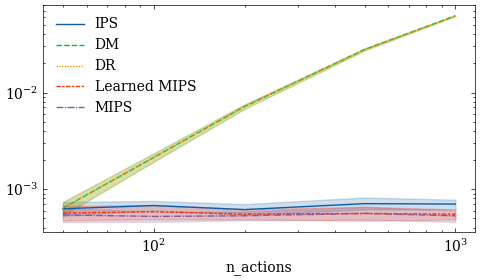

,IPS,DM,DR,Learned MIPS,MIPS
n_actions,,,,,
50.0,0.63±0.05,0.64±0.05,0.64±0.05,0.56±0.05,0.54±0.05
100.0,0.68±0.04,2.13±0.11,2.13±0.11,0.58±0.05,0.52±0.03
200.0,0.61±0.04,7.16±0.19,7.16±0.19,0.55±0.04,0.53±0.03
500.0,0.71±0.05,27.86±0.32,27.86±0.32,0.56±0.05,0.56±0.05
1000.0,0.70±0.04,62.33±0.31,62.33±0.31,0.55±0.03,0.53±0.04


In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

os.environ['PYTHONWARNINGS']='ignore::UserWarning'
plt.style.use(['science', 'no-latex'])

n_actions = [50, 100, 200, 500, 1000]
train_rounds = 1000

results = pd.concat(Parallel(n_jobs=-2)(delayed(ope)(a_num=a_num, train_rounds=train_rounds, n_iter=30, n_iter_big=50) for a_num in n_actions), ignore_index=True)
plt.subplots(figsize=(5, 3), tight_layout=True)
sns.lineplot(data=results.set_index('n_actions')[['IPS', 'DM', 'DR', 'Learned MIPS', 'MIPS']])
plt.xscale('log')
plt.yscale('log')
plt.show()

def mean_standard_error(serie):
    return f"{serie.mean():.2f}±{serie.std()/np.sqrt(len(serie)):.2f}"

results_a = results.copy()
results_a[['IPS', 'DM', 'DR', 'Learned MIPS', 'MIPS']] = results_a[['IPS', 'DM', 'DR', 'Learned MIPS', 'MIPS']].multiply(results_a['sample_size'], axis=0)
results_a.pivot_table(index='n_actions', aggfunc=mean_standard_error)[['IPS', 'DM', 'DR', 'Learned MIPS', 'MIPS']]